In [75]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [76]:
import os
directory = '/home/alexandre/Documents/TM/main/data/'
with open(os.path.join(directory,'dps.pickle'), 'rb') as file:
    dps = pickle.load(file)

dps = np.array(dps)

In [77]:

with open(os.path.join(directory,'grid.pickle'), 'rb') as file:
    grid = pickle.load(file)

grid = np.array(grid)

In [78]:
grid.shape

(20, 20)

In [79]:
df = pd.DataFrame(grid)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,19,24,17,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,16,10,0,9,20,7,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,23,0,0,0,0,12,23,6,0,0,0,0,0,0,0
4,0,0,0,0,18,6,0,0,0,0,0,0,31,16,0,0,0,0,0,0


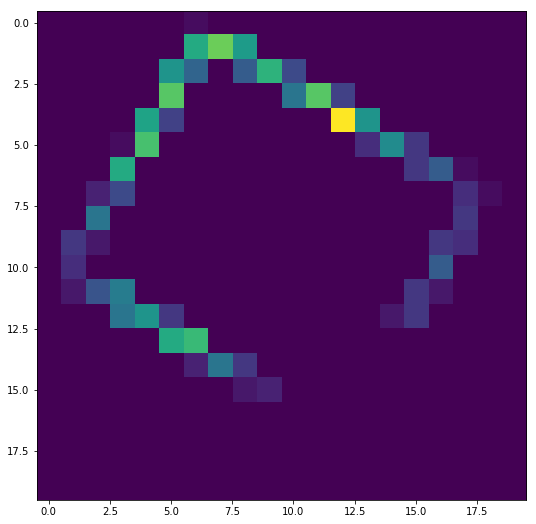

In [80]:
fig = plt.figure(figsize=(9,9))
plt.imshow(grid);

In [81]:
def get_dps(df):
    idx = df.replace(0,np.NaN).notna()
    dps = []
    for i in range(20):
        s = df[i][idx[i]]
        if s.size != 0:
            for e in s.index.values:
                dp = [i, 50-e]
                dps.append(dp)
    dps = np.array(dps)
    dps[:,1] -= 1
    return dps

In [92]:
from sklearn.cluster import KMeans
# count the amoud of != 0 values, (replace 0 by NaN, count the number of notNaN by column and get the sum)
n_clusters = round(dps.shape[0]/20)
kmeans = KMeans(n_clusters=n_clusters)


kmeans.fit(dps)
clean_dps = kmeans.cluster_centers_
clean_dps.shape

(18, 2)

In [93]:
# get the grid version
#dps = get_dps(df)
#clean_dps = dps

In [94]:
from scipy.spatial.distance import cdist

def closest_point(point, points):
    """ Find closest point from a list of points. """
    index = cdist([point], points).argmin()
    return points.iloc[index,:], points.iloc[[index,index-1],:].index[0]

def find_closest_dps(idx, dps):
    
    dp = dps.iloc[idx,:]
    c1dp, c1idx = closest_point(dp, dps.drop(idx,axis=0))

    c2dp, c2idx = closest_point(dp, dps.drop([idx, c1idx],axis=0))
    return c1dp, c2dp

def build_slines_from_unique(df_dps, unique):
    slines = []
    for name1, name2 in unique:
        dp1 = df_dps.iloc[name1,:]
        dp2 = df_dps.iloc[name2,:]
        slines.append((dp1, dp2))
    return slines

def drop_same_lines(slines, dps):
    names = []
    for sline in slines:
        cname = [sline[0].name, sline[1].name]
        cname.sort()
        names.append(cname)

    names = np.array(names)
    unique = np.unique(names, axis=0)
    slines = build_slines_from_unique(dps, unique)
    return slines

def link_dps(dps):
    slines = []
    for dp in dps.iterrows():
        idx, dp = dp
        # find closest dps
        cdp1, cdp2 = find_closest_dps(idx, dps)
        slines.append((dp,cdp1))
        slines.append((dp,cdp2))
    slines = drop_same_lines(slines, dps)
    return slines

def length(sline):
    dx = abs(sline[0][0] - sline[1][0])
    dy = abs(sline[0][1] - sline[1][1])
    l = np.sqrt(dx**2 + dy**2)
    return l

def get_max_distance(slines):
    line_lengths = []
    for sline in slines:
        l = length(sline)
        line_lengths.append(l)

    return max(line_lengths)


In [95]:
def check_for_isolated(slines):
    '''Check if one of the dps is linked  3 times'''
    # get the name of 
    names = []
    for sline in slines:
        cname = [sline[0].name, sline[1].name]
        cname.sort()
        names.append(cname)
    names = np.array(names)
    
    unique, counts = np.unique(names, return_counts=True)
    # check if a dp is linked 3 times
    return 3 in counts

In [96]:
def check_complete_grid(grid):
    # count the amoud of != 0 values, (replace 0 by NaN, count the number of notNaN by column and get the sum)
    n_clusters = np.sum(df.replace(0,np.NaN).count())
    kmeans = KMeans(n_clusters=n_clusters)

    dps = get_dps(df)

    kmeans.fit(dps)
    clean_dps = kmeans.cluster_centers_
    
    df_dps = pd.DataFrame(clean_dps, columns=['x','y'])
    slines = link_dps(df_dps)
    return not check_for_isolated(slines)


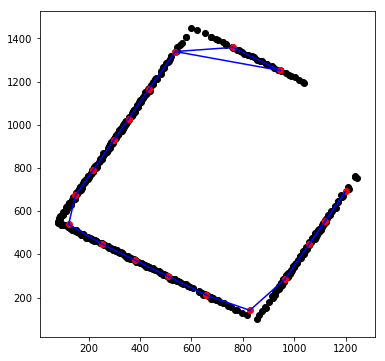

In [97]:
df_dps = pd.DataFrame(clean_dps, columns=['x','y'])
slines = link_dps(df_dps)

fig = plt.figure(figsize=(6,6))

for sline in slines:
    plt.plot((sline[0][0], sline[1][0]), (sline[0][1], sline[1][1]), c='blue')


# all obs
plt.scatter(dps[:,0], dps[:,1], c='black')
# cluster centers
plt.scatter(clean_dps[:,0], clean_dps[:,1], c='r')
plt.show()

In [98]:
# max distance between two following dps
get_max_distance(slines)

417.013490270957

In [99]:
# isolated dp
check_for_isolated(slines)

True

(67.83230154129606, 1254.116958500987, 79.66443806205305, 1419.6188952712807)

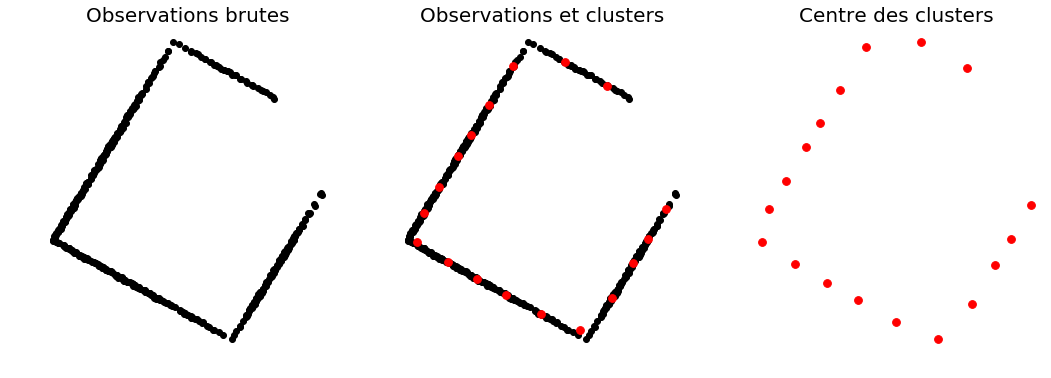

In [100]:
plt.rc('axes', titlesize=20) 

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

ax1.set_title('Observations brutes')
ax2.set_title('Observations et clusters')
ax3.set_title('Centre des clusters')


ax1.scatter(dps[:,0], dps[:,1], c='black')

ax2.scatter(dps[:,0], dps[:,1], c='black')
ax2.scatter(clean_dps[:,0], clean_dps[:,1], c='red', s=60)

ax3.scatter(clean_dps[:,0], clean_dps[:,1], c='red', s=60)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

#plt.savefig('kmeans-clean.png', bbox_inches='tight', pad_inches = 0)

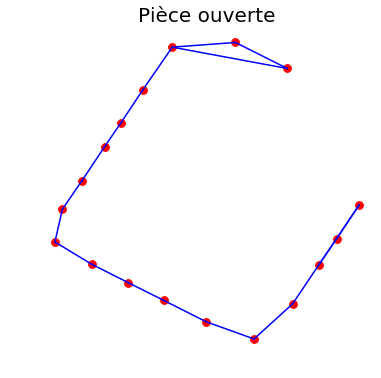

In [102]:
fig = plt.figure(figsize=(6,6))

plt.title('Pièce ouverte')

plt.scatter(clean_dps[:,0],clean_dps[:,1], c='red', s=60)

for sline in slines:
    plt.plot((sline[0][0], sline[1][0]), (sline[0][1], sline[1][1]), c='blue')

plt.axis('off')

plt.savefig('kmeans-p-ouverte.png', bbox_inches='tight', pad_inches = 0)